In [1]:

import numpy as np
import pandas as pd

from itertools  import product,combinations

from StrategyProfile import StrategyProfile
from aux_functions import minwidth_BBANDS, sharpe_ratio, brute_force_with_HoF


from numba import njit

import sys
sys.path.append("../") # add parent dir to the path
from IOimplementations.Bitcoincharts import *

%matplotlib inline
%load_ext autoreload
%autoreload 2


C:\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
C:\Anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


# Notebook description
Basic investigation of a mean revertion strategy on BTCUSD data, using Bollinger Bands. 
In the previous notebook we saw that doing MR trading all the time results in incosistent perfomance. 

### Using MACD to detect treding
Here we want to use MACD to determine whether the price is trending or not. 
In order to reduce the parameter space, we may configure the MACD parameters manually.
To that end, we use typical setting for MACD (12,26,9). 
Since trending is going to take place at a larger timescale than mean revertion.
Since the parameters of the Bollinger bands are <~100, I multiply the MACD settings by 10 - resulting in (120,260,90). 

### Strategy
- **Go short if**: 
 - the price is above the top Bollinger Band (BB) 
 - the MACD is below the signal (not trending up)
- Exit short if the above conditions stop being true
- **Go long if**: 
 - the price is below the bottom Bollinger Band (BB) 
 - the MACD is above the signal (not trending down)
- Exit long if the above conditions stop being true
 
### Details
- We consider 5min bars. 
- We impose a minimum distance between the Bollinger Bands (of 10USD) (to deal with periods of extermely low volume/volatility)
- We optimise the strategy over sparse hyperparameter grid.

### Data
- We do not have information on the bid-ask spread. We buy/sell at closing prices.
- This causes problems (e.g. high frequency mean rev strategies get sharpe ~12 because they buy @ bid and sell @ ask price). 
- To avoid this, I impose a cost of 2.5 USD per transaction per BTC. 
- This value is based on the bid ask spread of BTCUSD around the time of the data (I manually checked Kraken).

### Measuring strategy perfomance
- We trade lots of constant size (1 BTC). Thus, PnL is the sum of the relative changes for every bar. This helps us deal with the (extreme) nonstationarity of the BTCUSD price.
- Based on their parameterisation, some strategies need more than other to 'wind up' (e.g. a MA of 150 bars needs at least 150 bars to place its first trade). Let's call this time the Transition Time (TT). 
- To avoid bias, we force all strategies to have the same TT. 


In [2]:

# Load data
df = Bitcoincharts_data_handling().load(symbol='krakenUSD', resolution='300S').ffill()
df = df.ffill()
p_ts = df.loc['2017-06-01':'2019-06-01']


# Strategy implementation

In [3]:

@njit 
def _decision_logic(p, bb_dn, bb_up, macd_bull, macd_bear):
    """ 
    Determines the positions baed on the provided indicators.
    
    This function uses a loop - which could be vectorised.
    However, using the loop is more flexibile.
    Specifically, it allows us to use path-dependant logic, and 
    understand the strategy more intuitively.
    """
    # Initialise arrays
    pos = np.zeros(len(p))
    
    for i in np.arange(1, len(p)-1):     # First and last values omitted.
        
        if   bb_dn[i]:
            if macd_bear[i]: pos[i] =  0   # May be trending down, exit
            else:            pos[i] =  1   # Go long
        elif bb_up[i]: 
            if macd_bull[i]: pos[i] =  0   # May be trending up, exit
            else:            pos[i] =  -1  # Go short
        else:          pos[i] = pos[i-1] # Keep position
            
    return pos


def macd_bb(p, 
       ma_ts, sigma, mid_width,
       fma_ts, sma_ts, sig_ts):
    
    from talib import MACD, EMA

    #### Obtain indicators/train logic
    (t_b, m_o, b_b) = minwidth_BBANDS(p['close'], 
                                      ma_ts, 
                                      sigma,
                                      mid_width) 
    bb_up = p['close'].values > t_b  
    bb_dn = p['close'].values < b_b 
    
    sma          = EMA(p['close'].values, sma_ts)
    macd, sig, _ = MACD(p['close'].values, 
                        fastperiod=fma_ts, 
                        slowperiod=sma_ts, 
                        signalperiod=sig_ts) 
    macd_bull = macd > sig 
    macd_bear = macd < sig
    
    #### Decision
    # The decision logic is implemented using a for loop - which allows for easily 
    # changing the strategy. The for loop in implemented by Numba, and declared 
    # extrenaly from the function. Here, Numba accelerates by ~x10.
    pos = _decision_logic(p.values, bb_dn, bb_up, macd_bull, macd_bear)
    pos = pd.Series(pos, index=p.index)
    
    #### Evaluate
    strat = StrategyProfile(pos, p)
    
    return strat


def detailed_plot(t_b, m_o, b_b, sharpe, pnl, p):
    cumpnl = pnl.cumsum()
    plt.figure(figsize=(60, 20))
    plt.plot(p.index, p.values, lw=0.4)
    plt.plot(p.index, m_o, color='crimson', alpha=0.3, lw=0.3, ls='--')
    plt.fill_between(p.index, t_b, b_b, color='crimson', alpha=0.3, lw=0)
    plt.gca().twinx().plot(cumpnl.index, cumpnl.values, color='black',   alpha=0.5, lw=0.4)    
    plt.grid()
    

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in less


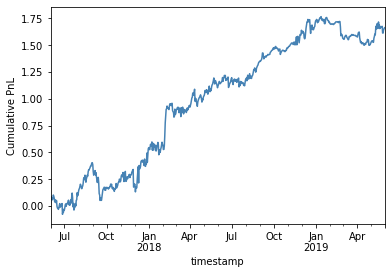

In [4]:

strat = macd_bb(
    p=p_ts, 
    ma_ts=10, sigma=2, mid_width=10, 
    fma_ts=200, sma_ts=600, sig_ts=200)
strat.simple_visualisation()


# Parameter sweep (without transaction costs)

In [35]:

# Define how we measure strategy perfomance
metric = lambda strategy_profile: strategy_profile.get_sharpe(tx_cost=0)

# Get the 5 best strategies in the search space
HoF, HoF_args = brute_force_with_HoF(
    bars=p_ts, 
    strategy=macd_bb, 
    parameters_dict={
        'ma_ts': np.linspace(15, 10*12, 5, endpoint=True, dtype=int),
        'sigma':   np.linspace(1, 3, 5, endpoint=True, dtype=float)
    }, 
    const_args={
        'mid_width':10,
        'fma_ts':120,
        'sma_ts':260,
        'sig_ts':120
    }, 
    score_key=metric, 
    n_hof=5)

# Print the strategies, along with performance:
for i in range(len(HoF)):
    print(i, HoF_args[i], metric(HoF[i]))


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in less


0 {'ma_ts': 41, 'sigma': 2.5} 2.1755754543845547
1 {'ma_ts': 41, 'sigma': 2.0} 2.128307944623884
2 {'ma_ts': 67, 'sigma': 2.5} 1.7926102764147545
3 {'ma_ts': 15, 'sigma': 1.5} 1.7415897433993606
4 {'ma_ts': 15, 'sigma': 2.0} 1.6657827261018932


# Conculsion:
We can see that the moving average of the Bollinger Bands should be aroung 41. The number of sigmas defining the width of the band is not too important - and may be 2, or 2.5.

BEST STRATEGY
Mean value of trades per day = 1.6643835616438356


Start date,2017-06-01
End date,2019-06-01
Total months,34
,Backtest
Annual return,119.1%
Cumulative returns,873.0%
Annual volatility,41.9%
Sharpe ratio,2.08
Calmar ratio,4.11
Stability,0.96
Max drawdown,-29.0%


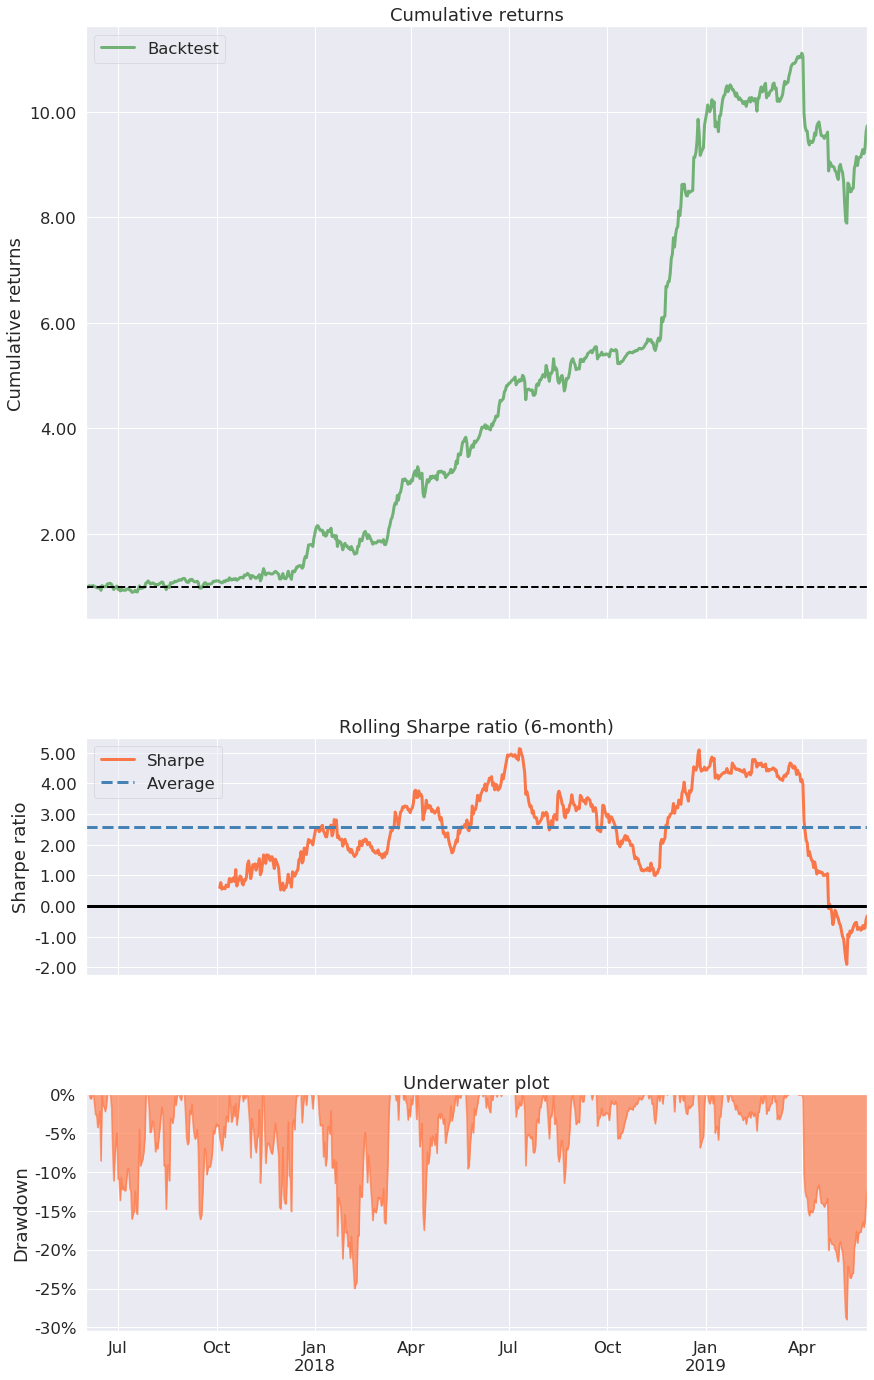

In [36]:

# Present the best strategy
print('BEST STRATEGY')
HoF[0].report()



# Conlusions

- **As you can see we get a sharpe of 2.14 and ~31.6trades per day**. 

- **HOWEVER the strategy is nonstationary** it does fantastically well a tiny fraction of the time.

- **Nonstationarity is a flaw resulting from the fitting process** The sparse search 'stupidly' fits in a way to maximally exploit the extreme mean revertion around the BTC bubble. This results in very incosistent perfomance.

- This **needs** to be fixed, this strategy is was to incosistent.


# Using a new perfomance metric
We will not be comparing strategies based on sharpe. Instead we will calculate the sharpe for every month, and take the min of all months.
This metric will help us avoid pathological strategies, that rely on anomalies.

In [48]:

# New perfomance metric: minimum sharpe of all months
metric = lambda x: x.get_pnl().groupby(
    pd.Grouper(freq='M')).apply(sharpe_ratio).min()

# Get the 5 best strategies in the search space
HoF, HoF_args = brute_force_with_HoF(
    bars=p_ts, 
    strategy=macd_bb, 
    parameters_dict={
        'ma_ts': np.linspace(15, 10*12, 5, endpoint=True, dtype=int),
        'sigma': np.linspace(1, 3, 5, endpoint=True, dtype=float)
    }, 
    const_args={
        'mid_width':10,
        'fma_ts':120,
        'sma_ts':260,
        'sig_ts':120
    }, 
    score_key=metric, 
    n_hof=5)

# Print the strategies, along with performance:
for i in range(len(HoF)):
    print(i, HoF_args[i],'MIN monthly sharpe:'+str( metric(HoF[i])) )


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in less


0 {'ma_ts': 67, 'sigma': 2.5} MIN monthly sharpe:-2.592856697837147
1 {'ma_ts': 67, 'sigma': 3.0} MIN monthly sharpe:-3.3321165559056616
2 {'ma_ts': 15, 'sigma': 2.0} MIN monthly sharpe:-3.352783578358334
3 {'ma_ts': 41, 'sigma': 1.0} MIN monthly sharpe:-3.3639362125780083
4 {'ma_ts': 93, 'sigma': 1.5} MIN monthly sharpe:-3.9375812759572675


In [32]:
shape(HoF)

NameError: name 'shape' is not defined

# Conclusion
We have found a relatively robust optimum
We can see that the ma_ts parameter can range between 93 and 41 without significantly impacting the sharpe. Same goes for the band width (which can be either 2 or 2.5).

Mean value of trades per day = 1.1602739726027398


Start date,2017-06-01
End date,2019-06-01
Total months,34
,Backtest
Annual return,69.4%
Cumulative returns,361.1%
Annual volatility,34.9%
Sharpe ratio,1.68
Calmar ratio,3.43
Stability,0.92
Max drawdown,-20.2%


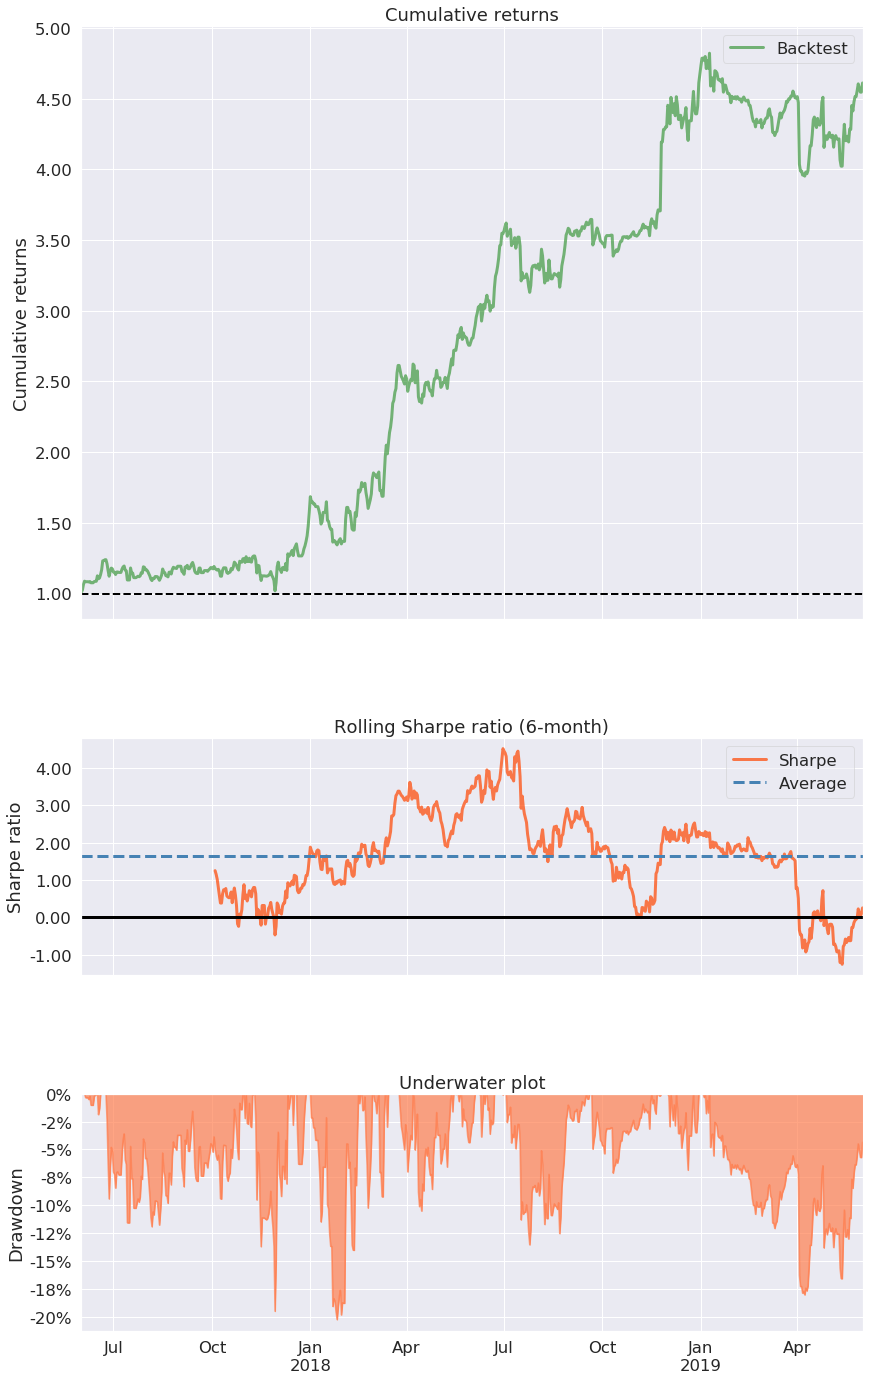

In [49]:

HoF[0].report()


- The sharpe is still somewhat unrealistic. 
- Also the strategy is clearly dependant on regimes (we can are consistently losing money during low volatility, strong trend regimes)

# Conclusions:
- **The strategy has improved considerably**
We have a decent sharpe, and reasonable trading frequencies. 

- **But it is still perfoming incosistently.**
We are not making profits for a big fraction of the time.



# Overall conclusions:

- Using basic indicators we can get a decent sharpe, with about 1 trade per day. Thus, it seems that mean revertion is a promising direction for BTCUSD.
- The strategy is entirely regime dependant - losing consistently during low volatility periods, and strong trend regimes.


# Next steps
- Think of better ways to capture trending behaviour.
